In [1]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from xgboost import XGBClassifier
import joblib

In [2]:
# NBA API - Get NBA games data from 2017-18 season to today
date_from = '2017-10-1'
date_to = datetime.today().strftime('%Y-%m-%d')

gamefinder = leaguegamefinder.LeagueGameFinder(date_from_nullable=date_from, date_to_nullable=date_to)
games_df = gamefinder.get_data_frames()[0]

# Filter only regular season games
# SEASON_ID:
#   1xxxx - Pre-Season
#   2xxxx - Regular Season
#   3xxxx - All-Star
#   4xxxx - Playoffs
#   5xxxx - Play-In
df = games_df[games_df['SEASON_ID'].astype(str).str.startswith('2')]

# Save the DataFrame to a Parquet file for future use
df.to_parquet('../dataframes/nba_games_2017_today.parquet', index=False)
pd.set_option('display.max_columns', None)

#### Random Forest Classifier for Game Outcome Prediction (without feature engineering)

In [3]:
# Format date and create target variable
df_clean = df.copy()
df_clean['GAME_DATE'] = pd.to_datetime(df_clean['GAME_DATE'])
df_clean['WIN'] = df_clean['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Encode categorical features
le = LabelEncoder()
categorical_features = ['TEAM_ID', 'MATCHUP', 'SEASON_ID', 'GAME_ID']
for feature in categorical_features:
    df_clean[feature] = le.fit_transform(df_clean[feature])

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      2085
           1       0.71      0.70      0.70      2051

    accuracy                           0.71      4136
   macro avg       0.71      0.71      0.71      4136
weighted avg       0.71      0.71      0.71      4136



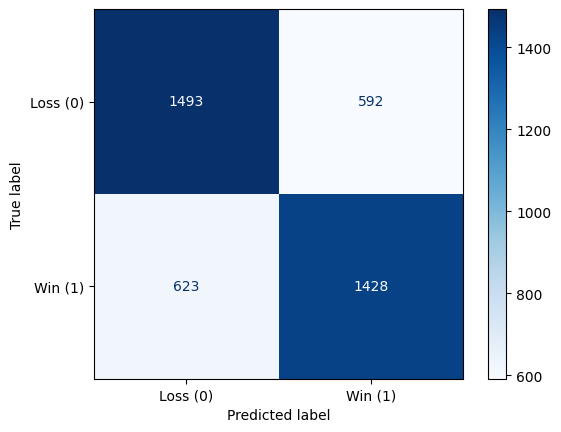

In [4]:
features = ['SEASON_ID', 'TEAM_ID', 'MATCHUP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'TOV']

X = df_clean[features]
y = df_clean['WIN']

# Split the data into training and testing sets and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss (0)', 'Win (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

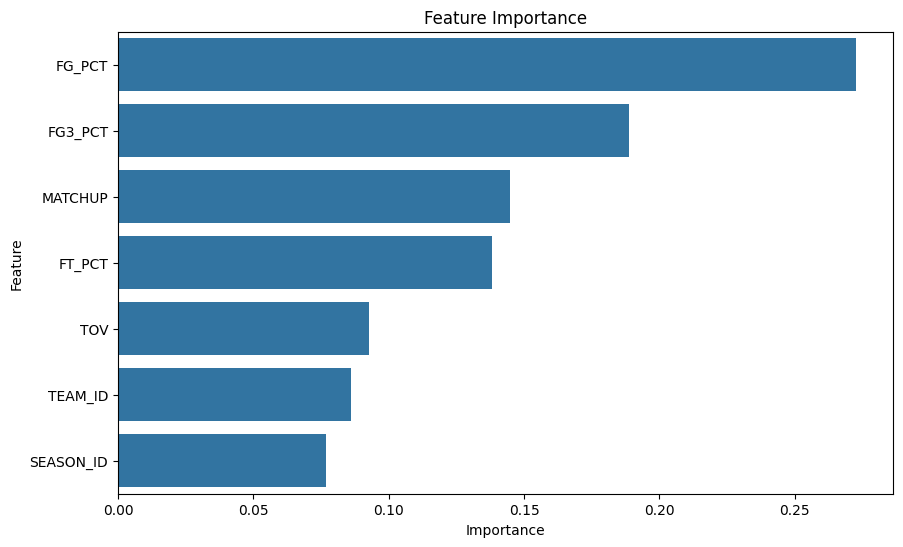

In [5]:
# Feature importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

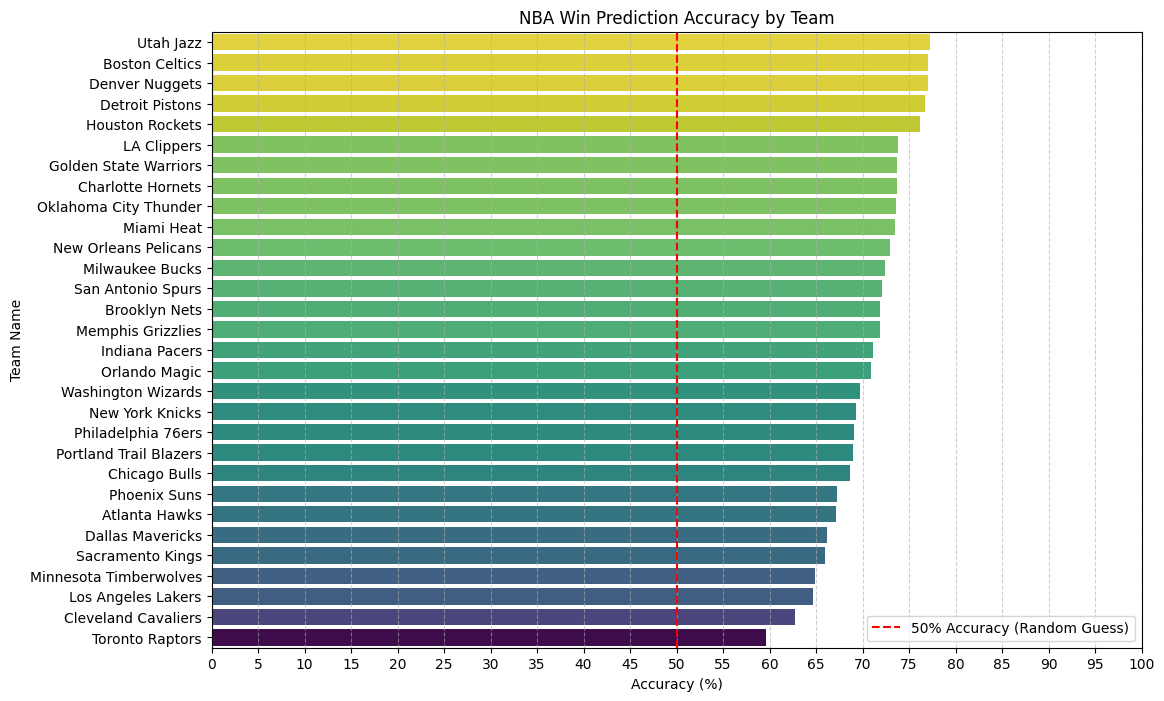

In [6]:
# Analyze accuracy by team

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

results_df['Team Name'] = df.loc[y_test.index, 'TEAM_NAME']

results_df['Correct Prediction'] = results_df['Actual'] == results_df['Predicted']

team_accuracy = results_df.groupby('Team Name')['Correct Prediction'].mean().reset_index()
team_accuracy.columns = ['Team Name', 'Accuracy']
team_accuracy = team_accuracy.sort_values(by='Accuracy', ascending=False)
team_accuracy['Accuracy_PCT'] = (team_accuracy['Accuracy'] * 100).round(2)

# Vizualize team accuracy
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy_PCT', y='Team Name', data=team_accuracy, palette='viridis', hue='Accuracy_PCT', dodge=False, legend=False,)
plt.axvline(x=50, color='red', linestyle='--', label='50% Accuracy (Random Guess)')
plt.xticks(np.arange(0, 101, 5))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlabel('Accuracy (%)')
plt.ylabel('Team Name')
plt.title('NBA Win Prediction Accuracy by Team')
plt.legend()
plt.show()

#### Feature Engineering

In [7]:
pd.set_option('display.max_columns', None)

# Feature Engineering

df_main = pd.read_parquet('../dataframes/nba_games_2017_today.parquet')
df_main = df_main.sort_values(by=['SEASON_ID', 'TEAM_ID', 'GAME_DATE'])
season_grouped = df_main.groupby(['SEASON_ID', 'TEAM_ID'])

# 'DAYS_BETWEEN_GAMES'
df_main['GAME_DATE'] = pd.to_datetime(df_main['GAME_DATE'])
df_main['DAYS_BETWEEN_GAMES'] = df_main.groupby('TEAM_ID')['GAME_DATE'].diff().dt.days

# 'WINS_LAST_5_GAMES'
df_main['WIN'] = df_main['WL'].map({'W': 1, 'L': 0})
df_main['WINS_LAST_5_GAMES'] = season_grouped['WIN'].rolling(window=5, min_periods=0).sum().shift(1).reset_index(0, drop=True).reset_index(0, drop=True)

# 'SEASON_RECORD_PCT'
WINS_BEFORE = season_grouped['WIN'].transform(lambda x: x.shift(1).cumsum())
GAMES_PLAYED_BEFORE = season_grouped.cumcount()
df_main['SEASON_RECORD_PCT'] = (WINS_BEFORE / GAMES_PLAYED_BEFORE).fillna(0.0)

# 'GAME_COUNT'
df_main['GAME_COUNT'] = season_grouped.cumcount() + 1

df_main['PTS'] = df_main['PTS'].astype(float)
df_main['PLUS_MINUS'] = df_main['PLUS_MINUS'].astype(float)

# 'ROLLING_PTS_PER_GAME' (last 5 games) 
df_main['ROLLING_PTS_PER_GAME'] = season_grouped['PTS'].rolling(window=5, min_periods=1).mean().shift(1).reset_index(drop=True)

# 'ROLLING_PLUS_MINUS_PER_GAME' (last 5 games)
df_main['ROLLING_PLUS_MINUS_PER_GAME'] = season_grouped['PLUS_MINUS'].rolling(window=5, min_periods=1).mean().shift(1).reset_index(drop=True)

# 'SEASON_FG_PCT'
df_main['SEASON_FG_PCT'] = season_grouped['FG_PCT'].expanding().mean().shift(1).reset_index(drop=True)

# 'SEASON_FG3_PCT'
df_main['SEASON_FG3_PCT'] = season_grouped['FG3_PCT'].expanding().mean().shift(1).reset_index(drop=True)

# 'SEASON_FT_PCT'
df_main['SEASON_FT_PCT'] = season_grouped['FT_PCT'].expanding().mean().shift(1).reset_index(drop=True)

# 'SEASON_REB_PER_GAME'
df_main['SEASON_REB_PER_GAME'] = season_grouped['REB'].expanding().mean().shift(1).reset_index(drop=True)

# 'SEASON_TOV_PER_GAME'
df_main['SEASON_TOV_PER_GAME'] = season_grouped['TOV'].expanding().mean().shift(1).reset_index(drop=True)

# 'IS_B2B' (games on consecutive days)
df_main['IS_B2B'] = (df_main['DAYS_BETWEEN_GAMES'] == 1).astype(int)

# Eliminate NaNs by filling with 0 (for the first games)
df_main = df_main.fillna(0)

# Round percentages to 3 decimal places
round_cols = ['SEASON_RECORD_PCT', 'ROLLING_PTS_PER_GAME', 'ROLLING_PLUS_MINUS_PER_GAME', 'SEASON_FG_PCT', 'SEASON_FG3_PCT', 'SEASON_FT_PCT', 'SEASON_REB_PER_GAME', 'SEASON_TOV_PER_GAME']
df_main[round_cols] = df_main[round_cols].round(3)

df_main.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,DAYS_BETWEEN_GAMES,WIN,WINS_LAST_5_GAMES,SEASON_RECORD_PCT,GAME_COUNT,ROLLING_PTS_PER_GAME,ROLLING_PLUS_MINUS_PER_GAME,SEASON_FG_PCT,SEASON_FG3_PCT,SEASON_FT_PCT,SEASON_REB_PER_GAME,SEASON_TOV_PER_GAME,IS_B2B
20657,22017,1610612737,ATL,Atlanta Hawks,0021700009,2017-10-18,ATL @ DAL,W,241,117.0,48,94,0.511,9,18,0.500,12,15,0.800,14,36,50,20,11,6,13,18,6.0,0.0,1,0.0,0.000,1,119.0,4.4,0.459,0.371,0.816,44.750,14.861,0
20628,22017,1610612737,ATL,Atlanta Hawks,0021700017,2017-10-20,ATL @ CHA,L,241,91.0,36,95,0.379,7,30,0.233,12,14,0.857,6,32,38,19,11,4,13,29,-22.0,2.0,0,1.0,1.000,2,118.8,-2.2,0.480,0.389,0.818,45.714,15.571,0
20596,22017,1610612737,ATL,Atlanta Hawks,0021700038,2017-10-22,ATL @ BKN,L,239,104.0,32,94,0.340,7,27,0.259,33,36,0.917,16,32,48,21,6,2,16,25,-12.0,2.0,0,1.0,0.500,3,120.8,14.0,0.482,0.345,0.741,47.286,14.893,0
20588,22017,1610612737,ATL,Atlanta Hawks,0021700042,2017-10-23,ATL @ MIA,L,240,93.0,36,76,0.474,7,17,0.412,14,18,0.778,6,35,41,14,9,1,20,17,-11.0,1.0,0,1.0,0.333,4,122.4,3.0,0.490,0.359,0.738,46.400,15.050,1
20541,22017,1610612737,ATL,Atlanta Hawks,0021700065,2017-10-26,ATL @ CHI,L,240,86.0,32,81,0.395,11,28,0.393,11,13,0.846,7,33,40,22,10,5,10,23,-5.0,3.0,0,1.0,0.250,5,114.8,-3.4,0.461,0.363,0.739,43.769,15.731,0


In [8]:
# Modify the dataset to have one row per game, with separate columns for home and away teams

df_main['IS_HOME'] = df_main['MATCHUP'].str.contains(' vs. ')

df_main_home = df_main[df_main['IS_HOME']]
df_main_away = df_main[~df_main['IS_HOME']]

df_main_home = df_main_home.add_prefix('HOME_')
df_main_away = df_main_away.add_prefix('AWAY_')

df_games = pd.merge(
    df_main_home,
    df_main_away,
    left_on=['HOME_GAME_ID'],
    right_on=['AWAY_GAME_ID']
)

# Feature Engineering
# 'REST_DIFF'
df_games['REST_DIFF'] = df_games['HOME_DAYS_BETWEEN_GAMES'] - df_games['AWAY_DAYS_BETWEEN_GAMES']

df_games = df_games.rename(columns={
    'HOME_SEASON_ID': 'SEASON_ID',
    'HOME_GAME_ID': 'GAME_ID',
    'HOME_GAME_DATE': 'GAME_DATE',
    'HOME_MATCHUP': 'MATCHUP',
    'HOME_PLUS_MINUS': 'PLUS_MINUS'
})

cols_to_drop = ['HOME_WL', 'HOME_IS_HOME', 'AWAY_SEASON_ID', 'AWAY_GAME_ID', 'AWAY_GAME_DATE', 'AWAY_MATCHUP', 'AWAY_WL', 'AWAY_PLUS_MINUS', 'AWAY_IS_HOME', 'AWAY_WIN']
df_games = df_games.drop(columns=cols_to_drop)

# Encode categorical features
le_main = LabelEncoder()
categorical_features_main = ['SEASON_ID', 'GAME_ID', 'MATCHUP', 'HOME_TEAM_ID', 'AWAY_TEAM_ID']
for feature in categorical_features_main:
    df_games[feature] = le_main.fit_transform(df_games[feature])

df_games.head()

,SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,PLUS_MINUS,HOME_DAYS_BETWEEN_GAMES,HOME_WIN,HOME_WINS_LAST_5_GAMES,HOME_SEASON_RECORD_PCT,HOME_GAME_COUNT,HOME_ROLLING_PTS_PER_GAME,HOME_ROLLING_PLUS_MINUS_PER_GAME,HOME_SEASON_FG_PCT,HOME_SEASON_FG3_PCT,HOME_SEASON_FT_PCT,HOME_SEASON_REB_PER_GAME,HOME_SEASON_TOV_PER_GAME,HOME_IS_B2B,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,AWAY_TEAM_NAME,AWAY_MIN,AWAY_PTS,AWAY_FGM,AWAY_FGA,AWAY_FG_PCT,AWAY_FG3M,AWAY_FG3A,AWAY_FG3_PCT,AWAY_FTM,AWAY_FTA,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_DAYS_BETWEEN_GAMES,AWAY_WINS_LAST_5_GAMES,AWAY_SEASON_RECORD_PCT,AWAY_GAME_COUNT,AWAY_ROLLING_PTS_PER_GAME,AWAY_ROLLING_PLUS_MINUS_PER_GAME,AWAY_SEASON_FG_PCT,AWAY_SEASON_FG3_PCT,AWAY_SEASON_FT_PCT,AWAY_SEASON_REB_PER_GAME,AWAY_SEASON_TOV_PER_GAME,AWAY_IS_B2B,REST_DIFF
0,0,0,ATL,Atlanta Hawks,71,2017-10-27,6,241,100.0,37,89,0.416,14,33,0.424,12,12,1.000,11,32,43,23,7,4,12,21,-3.0,1.0,0,1.0,0.200,6,112.8,-17.4,0.459,0.368,0.729,45.545,17.636,1,6,DEN,Denver Nuggets,240,105.0,42,91,0.462,4,20,0.200,17,23,0.739,11,35,46,25,8,4,11,12,2.0,1.0,0.250,5,104.6,-23.2,0.453,0.365,0.725,45.500,17.400,0,-1.0
1,0,0,ATL,Atlanta Hawks,84,2017-10-29,15,239,106.0,36,77,0.468,13,29,0.448,21,26,0.808,3,28,31,27,9,2,16,21,-11.0,2.0,0,0.0,0.167,7,115.6,2.4,0.456,0.349,0.795,46.190,14.929,0,12,MIL,Milwaukee Bucks,241,117.0,44,81,0.543,13,26,0.500,16,21,0.762,5,38,43,30,9,3,14,27,3.0,3.0,0.600,6,111.0,-6.4,0.455,0.346,0.788,46.421,14.947,0,-1.0
2,0,0,ATL,Atlanta Hawks,122,2017-11-03,9,240,104.0,39,81,0.481,11,33,0.333,15,18,0.833,5,36,41,16,8,8,18,16,-15.0,2.0,0,0.0,0.125,9,119.4,-6.4,0.455,0.344,0.815,45.455,16.000,0,8,HOU,Houston Rockets,239,119.0,42,89,0.472,16,47,0.340,19,23,0.826,9,35,44,28,14,4,12,16,2.0,3.0,0.667,10,126.6,-7.8,0.458,0.354,0.811,45.467,15.467,0,0.0
3,0,0,ATL,Atlanta Hawks,145,2017-11-06,1,241,107.0,39,81,0.481,13,26,0.500,16,20,0.800,5,31,36,24,8,4,14,22,-3.0,1.0,0,1.0,0.200,11,111.6,0.0,0.476,0.353,0.774,43.029,13.824,1,1,BOS,Boston Celtics,240,110.0,39,81,0.481,14,36,0.389,18,22,0.818,7,35,42,28,3,3,13,21,1.0,5.0,0.800,11,101.2,1.2,0.479,0.359,0.767,42.484,14.161,1,0.0
4,0,0,ATL,Atlanta Hawks,203,2017-11-15,24,239,126.0,50,79,0.633,16,32,0.500,10,16,0.625,9,44,53,40,9,6,18,23,43.0,2.0,1,1.0,0.143,15,120.8,-2.8,0.487,0.368,0.801,44.565,14.174,0,21,SAC,Sacramento Kings,242,80.0,31,88,0.352,6,28,0.214,12,20,0.600,11,18,29,18,12,2,12,19,2.0,2.0,0.231,14,124.8,2.4,0.488,0.371,0.801,44.792,14.000,0,0.0


In [9]:
# Elo Rating System
# Elo changes based on game result and the Elo difference between teams
def add_elo(df):
    elo_dict = {}
    last_season_dict = {}

    k_factor = 40
    retention_rate = 0.75

    home_elo_before = []
    away_elo_before = []

    df = df.sort_values(by=['SEASON_ID', 'GAME_DATE'])

    for index, row in df.iterrows():
        home_team = row['HOME_TEAM_ID']
        away_team = row['AWAY_TEAM_ID']
        current_season = row['SEASON_ID']
        home_win = row['HOME_WIN']

        # Get current elo ratings for both teams, or default to 1500 if they haven't played before
        elo_home_current = elo_dict.get(home_team, 1500)
        elo_away_current = elo_dict.get(away_team, 1500)

        # Apply retention to the elo ratings if it's a new season
        if last_season_dict.get(home_team) != current_season:
            elo_home_current = (elo_home_current * retention_rate) + (1500 * (1 - retention_rate))
            last_season_dict[home_team] = current_season

        if last_season_dict.get(away_team) != current_season:
            elo_away_current = (elo_away_current * retention_rate) + (1500 * (1 - retention_rate))
            last_season_dict[away_team] = current_season

        # Save the current elos before the game
        home_elo_before.append(elo_home_current)
        away_elo_before.append(elo_away_current)

        # Calculate expected win probability for the home team
        expected_home_win = 1 / (1 + 10 ** ((elo_away_current - elo_home_current) / 400))

        # Update elos based on game result
        new_elo_home = elo_home_current + k_factor * (home_win - expected_home_win)
        new_elo_away = elo_away_current + k_factor * ((1 - home_win) - (1 - expected_home_win))

        # Save the new elos back to the dictionary
        elo_dict[home_team] = new_elo_home
        elo_dict[away_team] = new_elo_away
    
    # Add the elo ratings before the game as new columns
    df['HOME_ELO'] = home_elo_before
    df['AWAY_ELO'] = away_elo_before

    df['ELO_DIFF'] = df['HOME_ELO'] - df['AWAY_ELO']

    return df

def add_elo_momentum(df):
    df = df.copy()

    home_df = df[['GAME_ID', 'GAME_DATE', 'HOME_TEAM_ID', 'HOME_ELO']].rename(
        columns={'HOME_TEAM_ID': 'TEAM_ID', 'HOME_ELO': 'ELO'}
    )
    away_df = df[['GAME_ID', 'GAME_DATE', 'AWAY_TEAM_ID', 'AWAY_ELO']].rename(
        columns={'AWAY_TEAM_ID': 'TEAM_ID', 'AWAY_ELO': 'ELO'}
    )

    all_games = pd.concat([home_df, away_df]).sort_values(['TEAM_ID', 'GAME_DATE'])

    all_games['ELO_MOMENTUM'] = all_games.groupby('TEAM_ID')['ELO'].diff(4)
    all_games['ELO_MOMENTUM'] = all_games['ELO_MOMENTUM'].fillna(0)

    momentum_lookup = all_games[['GAME_ID', 'TEAM_ID', 'ELO_MOMENTUM']]

    df = df.merge(momentum_lookup, 
                  left_on=['GAME_ID', 'HOME_TEAM_ID'], 
                  right_on=['GAME_ID', 'TEAM_ID'], 
                  how='left').rename(columns={'ELO_MOMENTUM': 'HOME_ELO_MOMENTUM'})
    df = df.drop('TEAM_ID', axis=1)
    df = df.merge(momentum_lookup, 
                  left_on=['GAME_ID', 'AWAY_TEAM_ID'], 
                  right_on=['GAME_ID', 'TEAM_ID'], 
                  how='left').rename(columns={'ELO_MOMENTUM': 'AWAY_ELO_MOMENTUM'})
    df = df.drop('TEAM_ID', axis=1)

    df['MOMENTUM_DIFF'] = df['HOME_ELO_MOMENTUM'] - df['AWAY_ELO_MOMENTUM']

    return df

df_games = add_elo(df_games)
df_games = add_elo_momentum(df_games)

round_cols = ['HOME_ELO', 'AWAY_ELO', 'ELO_DIFF', 'HOME_ELO_MOMENTUM', 'AWAY_ELO_MOMENTUM', 'MOMENTUM_DIFF']
df_games[round_cols] = df_games[round_cols].round(3)

In [10]:
df_games.to_parquet('../dataframes/nba_games_history.parquet')

#### Random Forest Classifier for Game Outcome Prediction (after feature engineering)

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       696
           1       0.67      0.69      0.68       878

    accuracy                           0.64      1574
   macro avg       0.63      0.63      0.63      1574
weighted avg       0.64      0.64      0.64      1574



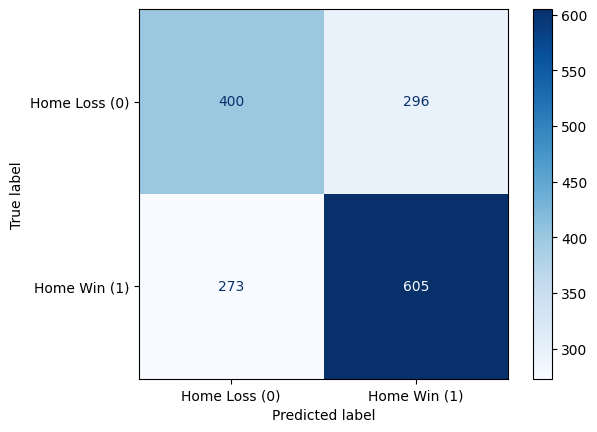

In [11]:
# Model Training with Engineered Features
# Use only from the 2019-20 season onwards to let the Elo ratings stabilize
df_games = df_games[df_games['SEASON_ID'] >= 2]

# Select features and target variable
features = [
    # 'SEASON_ID',
    'MATCHUP',
    # 'HOME_DAYS_BETWEEN_GAMES',
    'HOME_WINS_LAST_5_GAMES',
    'HOME_SEASON_RECORD_PCT',
    'HOME_GAME_COUNT',
    'HOME_ROLLING_PTS_PER_GAME',
    'HOME_ROLLING_PLUS_MINUS_PER_GAME',
    # 'HOME_SEASON_FG_PCT',
    # 'HOME_SEASON_FG3_PCT',
    # 'HOME_SEASON_FT_PCT',
    'HOME_SEASON_REB_PER_GAME',
    'HOME_SEASON_TOV_PER_GAME',
    # 'AWAY_DAYS_BETWEEN_GAMES',
    'AWAY_WINS_LAST_5_GAMES',
    'AWAY_SEASON_RECORD_PCT',
    'AWAY_GAME_COUNT',
    'AWAY_ROLLING_PTS_PER_GAME',
    'AWAY_ROLLING_PLUS_MINUS_PER_GAME',
    # 'AWAY_SEASON_FG_PCT',
    # 'AWAY_SEASON_FG3_PCT',
    # 'AWAY_SEASON_FT_PCT',
    'AWAY_SEASON_REB_PER_GAME',
    'AWAY_SEASON_TOV_PER_GAME',
    'HOME_ELO',
    'AWAY_ELO',
    'ELO_DIFF',
    'HOME_ELO_MOMENTUM',
    'AWAY_ELO_MOMENTUM',
    'MOMENTUM_DIFF',
    'REST_DIFF'
]

X = df_games[features]
y = df_games['HOME_WIN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_final = RandomForestClassifier(
    n_estimators=525,
    max_depth=5,
    class_weight='balanced',
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)
y_pred_final = rf_final.predict(X_test)
y_probs_final = rf_final.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_final))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Loss (0)', 'Home Win (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

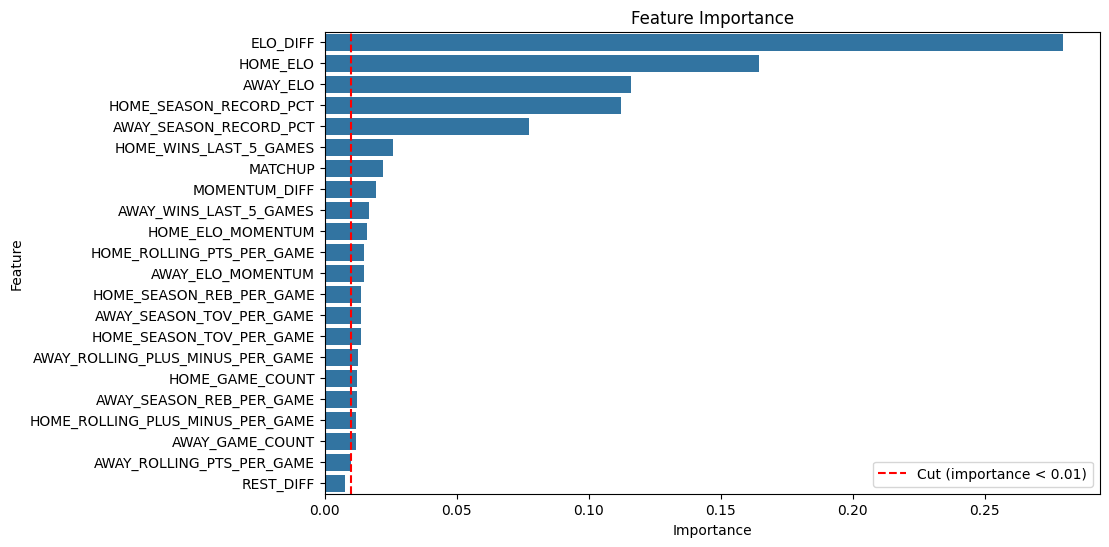

In [12]:
# Feature importance
importances = rf_final.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.axvline(x=0.01, color='red', linestyle='--', label='Cut (importance < 0.01)')
plt.title('Feature Importance')
plt.legend()
plt.show()

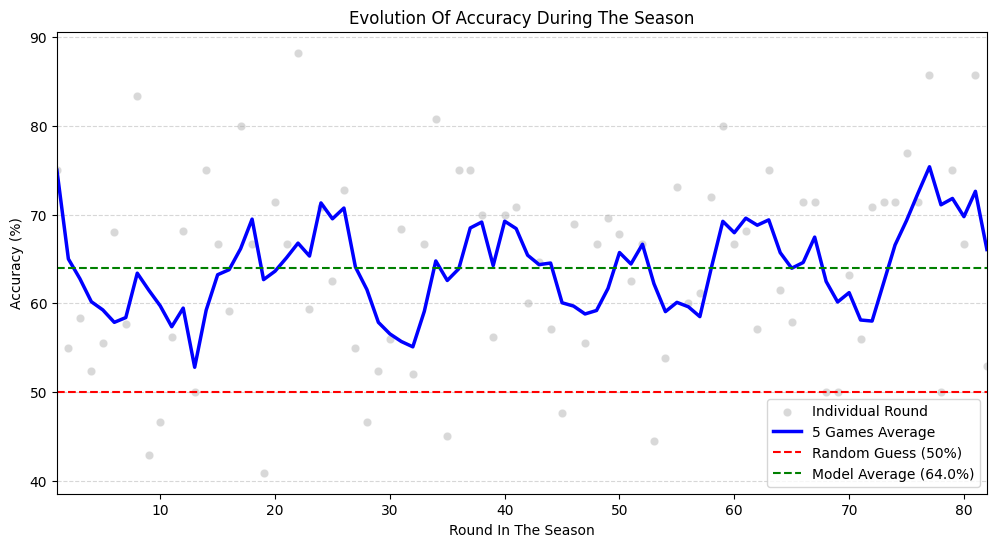

In [13]:
df_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_final
})

df_results['Round'] = df_games.loc[y_test.index, 'HOME_GAME_COUNT']
df_results['is_correct'] = df_results['Actual'] == df_results['Predicted']
round_accuracy = df_results.groupby('Round')['is_correct'].mean().reset_index(name='Accuracy')
round_accuracy['Accuracy_PCT'] = (round_accuracy['Accuracy'] * 100)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Round', y='Accuracy_PCT', data=round_accuracy, alpha=0.3, color='gray', label='Individual Round')
round_accuracy['Trend'] = round_accuracy['Accuracy_PCT'].rolling(window=5, min_periods=1).mean()
sns.lineplot(x='Round', y='Trend', data=round_accuracy, color='blue', linewidth=2.5, label='5 Games Average')
plt.axhline(y=50, color='red', linestyle='--', label='Random Guess (50%)')
plt.axhline(y=round_accuracy['Accuracy_PCT'].mean(), color='green', linestyle='--', label=f'Model Average ({round_accuracy["Accuracy_PCT"].mean():.1f}%)')
plt.xlabel('Round In The Season')
plt.ylabel('Accuracy (%)')
plt.title('Evolution Of Accuracy During The Season')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlim(1, 82)
plt.show()

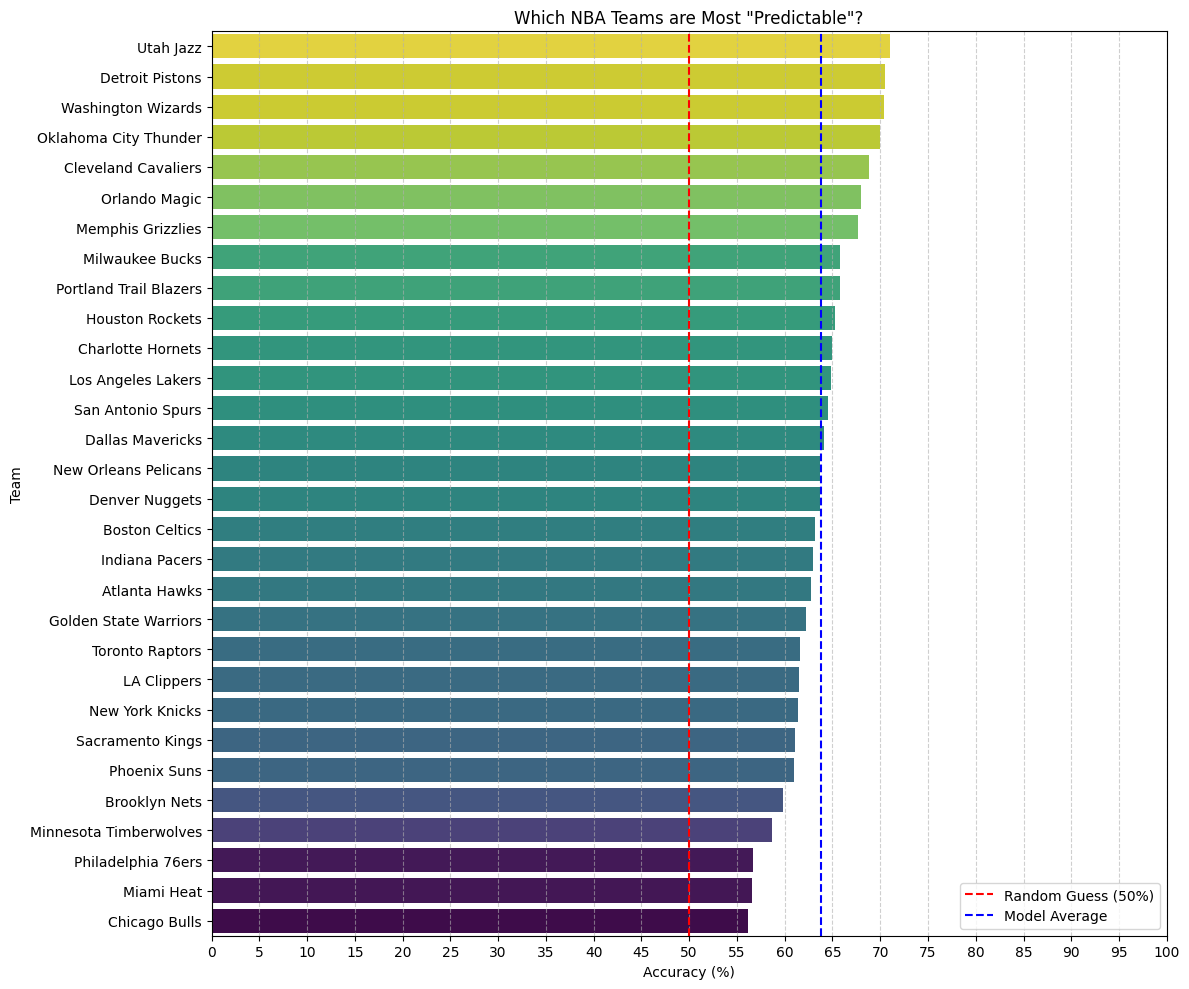

In [14]:
# Analyze accuracy by team with the new model
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_final
})

# Get team names using the index
results_df['Home_Team'] = df_games.loc[y_test.index, 'HOME_TEAM_NAME']
results_df['Away_Team'] = df_games.loc[y_test.index, 'AWAY_TEAM_NAME']

# Calculate if the prediction was correct for each game
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

home_stats = results_df[['Home_Team', 'Correct']].rename(columns={'Home_Team': 'Team'})
away_stats = results_df[['Away_Team', 'Correct']].rename(columns={'Away_Team': 'Team'})

all_team_results = pd.concat([home_stats, away_stats])

# Calculate accuracy for each team
team_accuracy = all_team_results.groupby('Team')['Correct'].mean().reset_index()
team_accuracy.columns = ['Team Name', 'Accuracy']
team_accuracy = team_accuracy.sort_values(by='Accuracy', ascending=False)
team_accuracy['Accuracy_PCT'] = (team_accuracy['Accuracy'] * 100).round(2)

# Vizualize team accuracy
plt.figure(figsize=(12, 10))

sns.barplot(
    x='Accuracy_PCT', 
    y='Team Name', 
    data=team_accuracy, 
    palette='viridis', 
    hue='Accuracy_PCT', 
    dodge=False, 
    legend=False
)

plt.axvline(x=50, color='red', linestyle='--', label='Random Guess (50%)')
plt.axvline(x=team_accuracy['Accuracy_PCT'].mean(), color='blue', linestyle='--', label='Model Average')

plt.xticks(np.arange(0, 101, 5))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlabel('Accuracy (%)')
plt.ylabel('Team')
plt.title('Which NBA Teams are Most "Predictable"?')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### XGBoost Classifier model

Ratio: 0.822
Best iteration: 299
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       696
           1       0.67      0.69      0.68       878

    accuracy                           0.64      1574
   macro avg       0.63      0.63      0.63      1574
weighted avg       0.63      0.64      0.63      1574



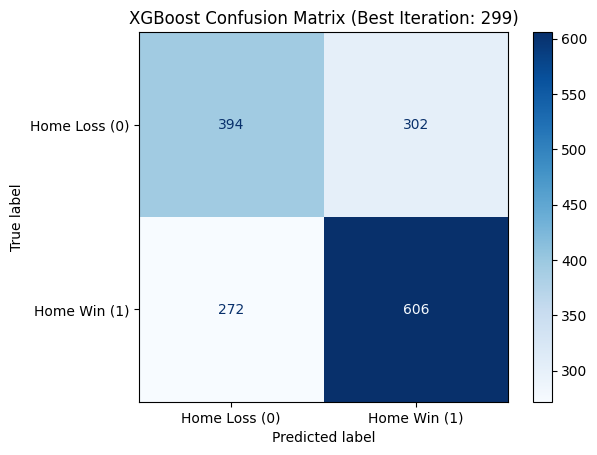

In [15]:
# XGBoost Classifier with Engineered Features (2019-20 season onwards)
df_games = df_games[df_games['SEASON_ID'] >= 2]

features_xgb = [
    'SEASON_ID',
    'MATCHUP',
    'HOME_DAYS_BETWEEN_GAMES',
    'HOME_WINS_LAST_5_GAMES',
    'HOME_SEASON_RECORD_PCT',
    'HOME_GAME_COUNT',
    'HOME_ROLLING_PTS_PER_GAME',
    'HOME_ROLLING_PLUS_MINUS_PER_GAME',
    'HOME_SEASON_FG_PCT',
    'HOME_SEASON_FG3_PCT',
    'HOME_SEASON_FT_PCT',
    'HOME_SEASON_REB_PER_GAME',
    'HOME_SEASON_TOV_PER_GAME',
    'HOME_IS_B2B',
    'AWAY_DAYS_BETWEEN_GAMES',
    'AWAY_WINS_LAST_5_GAMES',
    'AWAY_SEASON_RECORD_PCT',
    'AWAY_GAME_COUNT',
    'AWAY_ROLLING_PTS_PER_GAME',
    'AWAY_ROLLING_PLUS_MINUS_PER_GAME',
    'AWAY_SEASON_FG_PCT',
    'AWAY_SEASON_FG3_PCT',
    'AWAY_SEASON_FT_PCT',
    'AWAY_SEASON_REB_PER_GAME',
    'AWAY_SEASON_TOV_PER_GAME',
    'AWAY_IS_B2B',
    'REST_DIFF',
    'HOME_ELO',
    'AWAY_ELO',
    'ELO_DIFF',
    'HOME_ELO_MOMENTUM',
    'AWAY_ELO_MOMENTUM',
    'MOMENTUM_DIFF'
]

X = df_games[features_xgb]
y = df_games['HOME_WIN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Ratio: {ratio:.3f}")

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.005,
    max_depth=3,
    scale_pos_weight=ratio,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"Best iteration: {xgb_model.best_iteration}")

y_pred_xgb = xgb_model.predict(X_test)

proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Loss (0)', 'Home Win (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"XGBoost Confusion Matrix (Best Iteration: {xgb_model.best_iteration})")
plt.show()

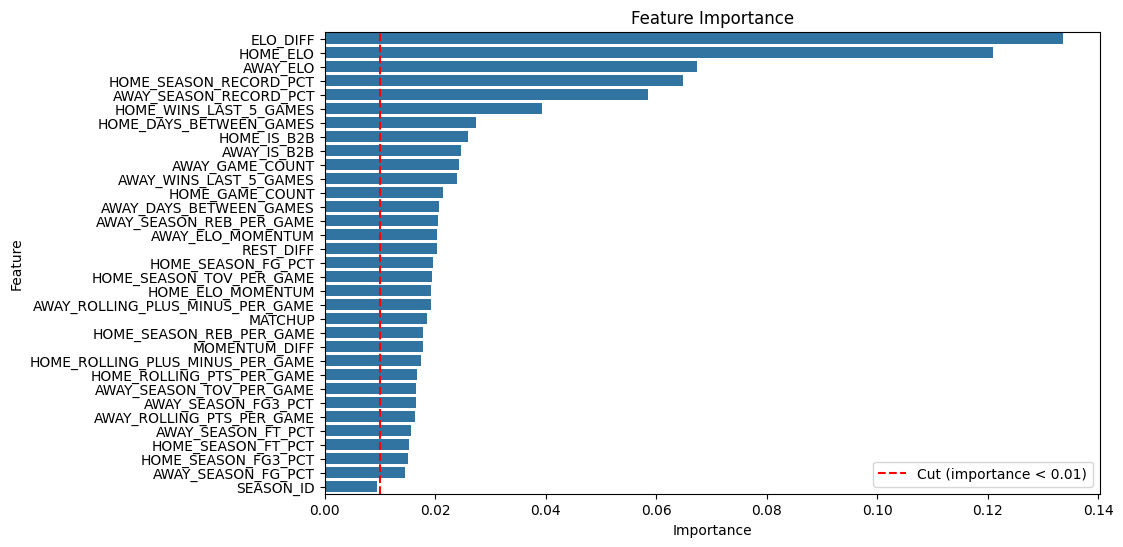

In [16]:
# Feature importance
importances = xgb_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.axvline(x=0.01, color='red', linestyle='--', label='Cut (importance < 0.01)')
plt.title('Feature Importance')
plt.legend()
plt.show()

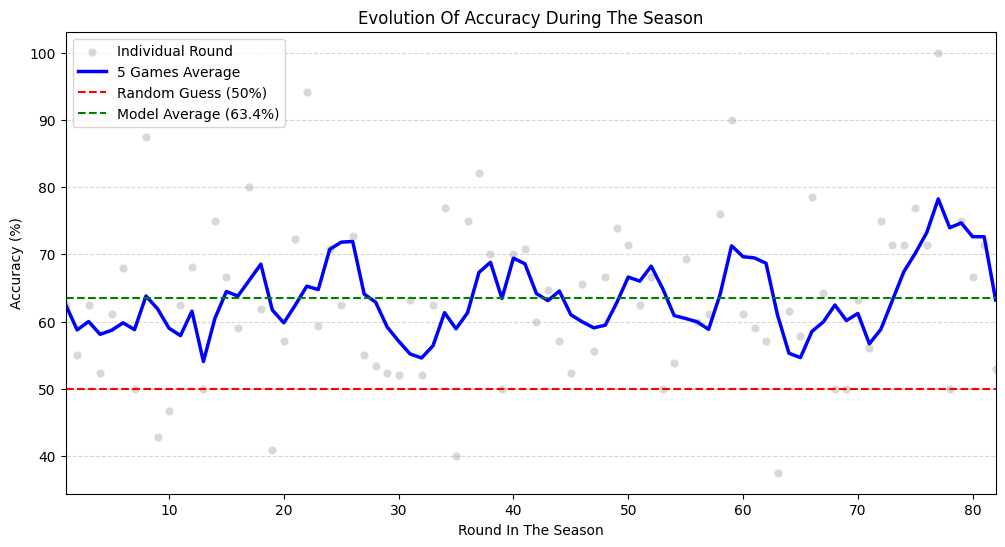

In [17]:
df_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb
})

df_results['Round'] = df_games.loc[y_test.index, 'HOME_GAME_COUNT']
df_results['is_correct'] = df_results['Actual'] == df_results['Predicted']
round_accuracy = df_results.groupby('Round')['is_correct'].mean().reset_index(name='Accuracy')
round_accuracy['Accuracy_PCT'] = (round_accuracy['Accuracy'] * 100)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Round', y='Accuracy_PCT', data=round_accuracy, alpha=0.3, color='gray', label='Individual Round')
round_accuracy['Trend'] = round_accuracy['Accuracy_PCT'].rolling(window=5, min_periods=1).mean()
sns.lineplot(x='Round', y='Trend', data=round_accuracy, color='blue', linewidth=2.5, label='5 Games Average')
plt.axhline(y=50, color='red', linestyle='--', label='Random Guess (50%)')
plt.axhline(y=round_accuracy['Accuracy_PCT'].mean(), color='green', linestyle='--', label=f'Model Average ({round_accuracy["Accuracy_PCT"].mean():.1f}%)')
plt.xlabel('Round In The Season')
plt.ylabel('Accuracy (%)')
plt.title('Evolution Of Accuracy During The Season')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlim(1, 82)
plt.show()

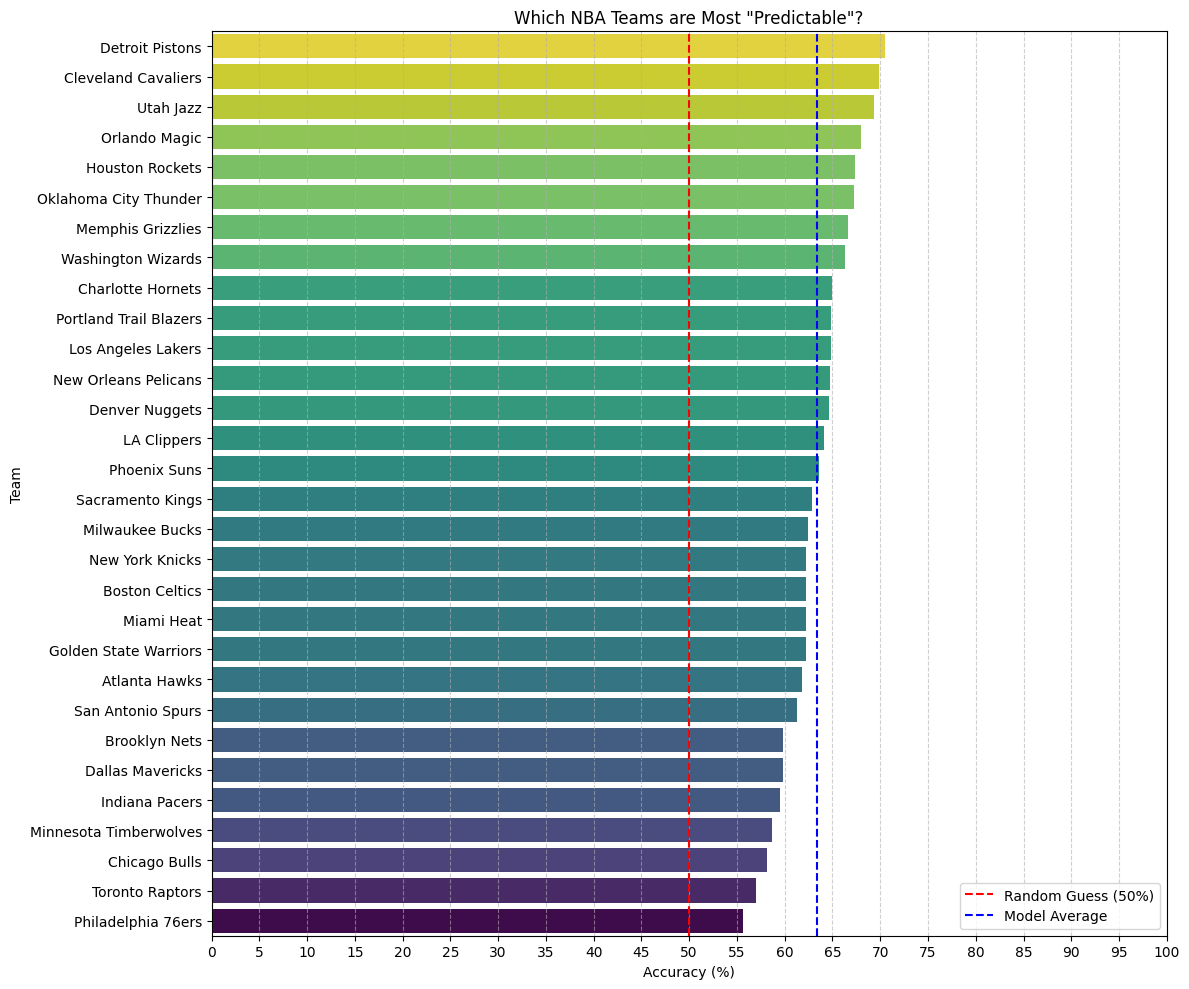

In [18]:
# Analyze accuracy by team with the XGBoost model
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb
})

# Get team names using the index
results_df['Home_Team'] = df_games.loc[y_test.index, 'HOME_TEAM_NAME']
results_df['Away_Team'] = df_games.loc[y_test.index, 'AWAY_TEAM_NAME']

# Calculate if the prediction was correct for each game
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

home_stats = results_df[['Home_Team', 'Correct']].rename(columns={'Home_Team': 'Team'})
away_stats = results_df[['Away_Team', 'Correct']].rename(columns={'Away_Team': 'Team'})

all_team_results = pd.concat([home_stats, away_stats])

# Calculate accuracy for each team
team_accuracy = all_team_results.groupby('Team')['Correct'].mean().reset_index()
team_accuracy.columns = ['Team Name', 'Accuracy']
team_accuracy = team_accuracy.sort_values(by='Accuracy', ascending=False)
team_accuracy['Accuracy_PCT'] = (team_accuracy['Accuracy'] * 100).round(2)

# Vizualize team accuracy
plt.figure(figsize=(12, 10))

sns.barplot(
    x='Accuracy_PCT', 
    y='Team Name', 
    data=team_accuracy, 
    palette='viridis', 
    hue='Accuracy_PCT', 
    dodge=False, 
    legend=False
)

plt.axvline(x=50, color='red', linestyle='--', label='Random Guess (50%)')
plt.axvline(x=team_accuracy['Accuracy_PCT'].mean(), color='blue', linestyle='--', label='Model Average')

plt.xticks(np.arange(0, 101, 5))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlabel('Accuracy (%)')
plt.ylabel('Team')
plt.title('Which NBA Teams are Most "Predictable"?')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [19]:
joblib.dump(xgb_model, '../xgb model/nba_model_xgb.pkl')
joblib.dump(features_xgb, '../xgb model/feature_list.pkl')

print("Model and features saved!")

Model and features saved!
